# Training a tokenizer

- In *Part3: Train GPT-2*, all the pieces of training GPT-2 from scratch were present *except* training the tokenizer.  For that, I took the GPT-2 tokenizer settings available from Hugging Face and trained a new tokenizer with a smaller vocabulary.  In this part, I'll attempt to train a GPT-2-style tokenizer from scratch following [Let's build the GPT Tokenizer](https://www.youtube.com/watch?v=zduSFxRajkE).  The custom tokenizer will not match the GPT-2 tokenizer exactly (likely since there are implementation details OpenAI didn't discuss) and will not be fast enough to use in it's base Python version.  However, the main goal here is to study the mechanics of the tokenization process.
- GPT-2 tokenizer uses the UTF-8 unicode encoding standard.  In the context of UTF-8, a code point is a unique numerical value assigned to a character, symbol, or glyph in the Unicode character set. UTF-8 encodes ASCII characters in 1 byte, and may use up to 4 bytes for non-ASCII characters as described in the following [Wikipedia article](https://en.wikipedia.org/wiki/UTF-8):

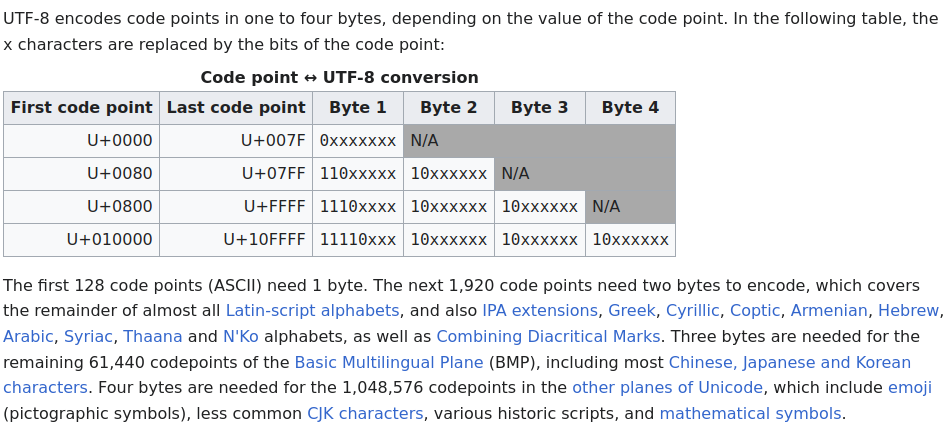

- Before the text is tokenized, it is converted to UTF-8.  This provides many advantages, including 
    - Unified representation across languages and scripts
    - Handling of rare tokens
    - Better handling of 'subwords' for languages where this concept is different than, say, that of standard English 

- A [sample](https://www.reedbeta.com/blog/programmers-intro-to-unicode/) of Unicode text is below:

In [15]:
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception. A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view. I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here."
tokens = text.encode("utf-8")
print(tokens)
tokens = list(map(int,tokens)) # convert to ints for convenience
print(tokens)
print(f"length of text: {len(text)}")
print(f"length of tokens: {len(tokens)}") #larger because complex characters become multiply bytes (up to 4)

b'\xef\xbc\xb5\xef\xbd\x8e\xef\xbd\x89\xef\xbd\x83\xef\xbd\x8f\xef\xbd\x84\xef\xbd\x85! \xf0\x9f\x85\xa4\xf0\x9f\x85\x9d\xf0\x9f\x85\x98\xf0\x9f\x85\x92\xf0\x9f\x85\x9e\xf0\x9f\x85\x93\xf0\x9f\x85\x94\xe2\x80\xbd \xf0\x9f\x87\xba\xe2\x80\x8c\xf0\x9f\x87\xb3\xe2\x80\x8c\xf0\x9f\x87\xae\xe2\x80\x8c\xf0\x9f\x87\xa8\xe2\x80\x8c\xf0\x9f\x87\xb4\xe2\x80\x8c\xf0\x9f\x87\xa9\xe2\x80\x8c\xf0\x9f\x87\xaa! \xf0\x9f\x98\x84 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to \xe2\x80\x9csupport Unicode\xe2\x80\x9d in our software (whatever that means\xe2\x80\x94like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don\xe2\x80\x99t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode\xe2\x80\x99s inception. A few months ago, I got intere

- The main idea of the Byte Pair Encoding (BPE) tokenizer is to identify and merge most common pairs, add them to vocabulary, and replace the common pairs with their merged representations.  This allows for more compact representations of text, allowing us to fit more information in our limited context window.  
- Andrej notes that he would like nothing less than to have models that work directly with Unicode code points, bypassing tokenization completely.  This would avoid many of the issues related to tokenization.  The main challenge with this approach currently is that the sequences would get too stretched out, allowing smaller effective context.
- My version of implementing the merging logic is below:

In [13]:
def most_common_pair(text,debug=False):
    """DPV's implementation of getting most common pair"""
    d = dict()
    for char1, char2 in zip(text[:-1],text[1:]):
        d[(char1,char2)] = d.get((char1,char2),0)+1
    max_pair= max(d,key = d.get)
    if debug:
        print(f"Number of occurrences at {max_pair} is {d[max_pair]}")
        print(d)
    return max_pair
most_common_pair(text,debug=True)


Number of occurrences at ('e', ' ') is 32
{('Ｕ', 'ｎ'): 1, ('ｎ', 'ｉ'): 1, ('ｉ', 'ｃ'): 1, ('ｃ', 'ｏ'): 1, ('ｏ', 'ｄ'): 1, ('ｄ', 'ｅ'): 1, ('ｅ', '!'): 1, ('!', ' '): 2, (' ', '🅤'): 1, ('🅤', '🅝'): 1, ('🅝', '🅘'): 1, ('🅘', '🅒'): 1, ('🅒', '🅞'): 1, ('🅞', '🅓'): 1, ('🅓', '🅔'): 1, ('🅔', '‽'): 1, ('‽', ' '): 1, (' ', '🇺'): 1, ('🇺', '\u200c'): 1, ('\u200c', '🇳'): 1, ('🇳', '\u200c'): 1, ('\u200c', '🇮'): 1, ('🇮', '\u200c'): 1, ('\u200c', '🇨'): 1, ('🇨', '\u200c'): 1, ('\u200c', '🇴'): 1, ('🇴', '\u200c'): 1, ('\u200c', '🇩'): 1, ('🇩', '\u200c'): 1, ('\u200c', '🇪'): 1, ('🇪', '!'): 1, (' ', '😄'): 1, ('😄', ' '): 1, (' ', 'T'): 1, ('T', 'h'): 1, ('h', 'e'): 8, ('e', ' '): 32, (' ', 'v'): 2, ('v', 'e'): 6, ('e', 'r'): 12, ('r', 'y'): 2, ('y', ' '): 3, (' ', 'n'): 3, ('n', 'a'): 1, ('a', 'm'): 5, ('m', 'e'): 9, (' ', 's'): 11, ('s', 't'): 7, ('t', 'r'): 5, ('r', 'i'): 6, ('i', 'k'): 2, ('k', 'e'): 2, ('e', 's'): 6, ('s', ' '): 18, (' ', 'f'): 9, ('f', 'e'): 2, ('e', 'a'): 5, ('a', 'r'): 13, ('r', ' '): 8, (' ', '

('e', ' ')

In [14]:
most_common_pair(tokens,debug=True)

Number of occurrences at (101, 32) is 32
{(239, 188): 1, (188, 181): 1, (181, 239): 1, (239, 189): 6, (189, 142): 1, (142, 239): 1, (189, 137): 1, (137, 239): 1, (189, 131): 1, (131, 239): 1, (189, 143): 1, (143, 239): 1, (189, 132): 1, (132, 239): 1, (189, 133): 1, (133, 33): 1, (33, 32): 2, (32, 240): 3, (240, 159): 15, (159, 133): 7, (133, 164): 1, (164, 240): 1, (133, 157): 1, (157, 240): 1, (133, 152): 1, (152, 240): 1, (133, 146): 1, (146, 240): 1, (133, 158): 1, (158, 240): 1, (133, 147): 1, (147, 240): 1, (133, 148): 1, (148, 226): 1, (226, 128): 18, (128, 189): 1, (189, 32): 1, (159, 135): 7, (135, 186): 1, (186, 226): 1, (128, 140): 6, (140, 240): 6, (135, 179): 1, (179, 226): 1, (135, 174): 1, (174, 226): 1, (135, 168): 1, (168, 226): 1, (135, 180): 1, (180, 226): 1, (135, 169): 1, (169, 226): 1, (135, 170): 1, (170, 33): 1, (159, 152): 1, (152, 132): 1, (132, 32): 1, (32, 84): 1, (84, 104): 1, (104, 101): 8, (101, 32): 32, (32, 118): 2, (118, 101): 6, (101, 114): 12, (114, 

(101, 32)

- Andrej splits this logic into the following two utility functions:

In [15]:
# Andrej's implementation
def get_stats(ids, counts=None):
    """
    Given a list of integers, return a dictionary of counts of consecutive pairs
    Example: [1, 2, 3, 1, 2] -> {(1, 2): 2, (2, 3): 1, (3, 1): 1}
    Optionally allows to update an existing dictionary of counts
    """
    counts = {} if counts is None else counts
    for pair in zip(ids, ids[1:]): # iterate consecutive elements
        counts[pair] = counts.get(pair, 0) + 1
    return counts
stats = get_stats(tokens)
top_pair = max(stats, key=stats.get)
top_pair

(101, 32)

In [16]:
def merge(ids, pair, idx):
    """Andrej's/DPV's implementations match"""
    i = 0
    out = []
    while i < len(ids):
        if (i<len(ids)-1) and(ids[i],ids[i+1])==pair:
            out.append(idx)
            i+=2 # merging!
        else:
            out.append(ids[i])
            i+=1 #moving by one
    return out
print(merge(tokens, top_pair, 256))

[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140, 240, 159, 135, 169, 226, 128, 140, 240, 159, 135, 170, 33, 32, 240, 159, 152, 132, 32, 84, 104, 256, 118, 101, 114, 121, 32, 110, 97, 109, 256, 115, 116, 114, 105, 107, 101, 115, 32, 102, 101, 97, 114, 32, 97, 110, 100, 32, 97, 119, 256, 105, 110, 116, 111, 32, 116, 104, 256, 104, 101, 97, 114, 116, 115, 32, 111, 102, 32, 112, 114, 111, 103, 114, 97, 109, 109, 101, 114, 115, 32, 119, 111, 114, 108, 100, 119, 105, 100, 101, 46, 32, 87, 256, 97, 108, 108, 32, 107, 110, 111, 119, 32, 119, 256, 111, 117, 103, 104, 116, 32, 116, 111, 32, 226, 128, 156

In [17]:
merge([5,6,6,7,9,1],(6,7),99)

[5, 6, 99, 9, 1]

- The following can be used to train the tokenizer, which in the BPE case amounts to finding and replacing the most common merge pairs:

In [18]:
# 'train' the tokenizer
vocab_size = 276
num_merges = vocab_size - 256
ids = list(tokens)
init_num_tokens = len(tokens)
print(init_num_tokens)
merges = dict()
for i in range(num_merges):
    stats = get_stats(tokens)
    top_pair = max(stats, key=stats.get)
    tokens = merge(tokens, top_pair, 256+i)
    merges[top_pair] = 256+i #don't forget to record that the pair of integers merged into newly minted int
final_num_tokens = len(tokens)
print(final_num_tokens)
print(f"compression ratio: {init_num_tokens/final_num_tokens:.2f}")


1116
847
compression ratio: 1.32


- Andrej notes that every time we merge tokens they become eligible for a merge in the next round.
- He also points out that the tokenizer is a completely separate step from the LLM training, it's main purpose being to convert raw text to sequences of integers.  The training step for the tokenizer may be different from the training data, perhaps being a multilingual mixture if we expect the model to be used with different languages in the future and we want compact representations for those languages.
- The following is a way to decode a Unicode string of bytes:

In [19]:
# Following Andrej, a bit thorny especially with error handling in .decode: 
# creating a mapping from byte values to byte objects, merging pairs of byte values into new byte objects, and providing a function to decode lists of byte values into strings.
vocab = {idx: bytes([idx]) for idx in range(256)}
for (p0,p1), idx in merges.items(): # runs in insertion order post Python 3.7
    vocab[idx] = vocab[p0] + vocab[p1]

def decode(ids):
    # given ids (lists of ints), return a string
    tokens = b"".join(vocab[idx] for idx in ids) # ids -> tokens in raw byte form
    text = tokens.decode("utf-8",errors='replace')  # raw bytes -> string; unicode chars can come in sequences of bytes and must come together to be decoded meaningfully 
    return text    

- The idea with encoding is to find the pair with the lowest index from the merges dictionary obtained during training.  This is because that pair got merged earliest. If there's nothing to merge (float('inf) returned),the pair would be the first element of stats and will not be in the merges dictionary.  We should then break out of the while loop.  

In [1]:
def encode(text):
    # Given a string, return list of integers (tokens)
    tokens = list(text.encode("utf-8"))
    while len(tokens)>=2: # need at least 2 chars else stats will be empty, causing an issue inside min
        stats = get_stats(tokens)
        top_pair = min(stats,key=lambda pair: merges.get(pair,float('inf')))
        if top_pair not in merges: break #nothing else can be merged
        idx = merges[top_pair]
        tokens = merge(tokens,top_pair,idx)
        #del merges[top_pair] # my original idea with 'while merges:', Andrej's is better
    return tokens            

## Basic tokenizer
- Following [Andrej's suggestion](https://github.com/karpathy/minbpe/blob/master/exercise.md), I implemented the basic BPE tokenizer as an exercise:

In [25]:
class BasicTokenizer:
    def __init__(self) -> None:
        self.merges = dict()
        #self.vocab_size = vocab_size
        
    @staticmethod
    def get_stats(ids, counts=None):
        """
        Given a list of integers, return a dictionary of counts of consecutive pairs
        Example: [1, 2, 3, 1, 2] -> {(1, 2): 2, (2, 3): 1, (3, 1): 1}
        Optionally allows to update an existing dictionary of counts
        """
        counts = {} if counts is None else counts
        for pair in zip(ids, ids[1:]): # iterate consecutive elements
            counts[pair] = counts.get(pair, 0) + 1
        return counts
    
    @staticmethod
    def merge(ids, pair, idx):
        """Andrej's/DPV's implementations match"""
        i = 0
        out = []
        while i < len(ids):
            if (i<len(ids)-1) and(ids[i],ids[i+1])==pair:
                out.append(idx)
                i+=2 # merging!
            else:
                out.append(ids[i])
                i+=1 #moving by one
        return out
    
    def train(self, text, vocab_size, verbose=False):
        #vocab_size = 276
        num_merges = vocab_size - 256
        tokens = text.encode("utf-8")
        print(f"tokens: {tokens}")
        init_num_tokens = len(tokens)
        for i in range(num_merges):
            stats = BasicTokenizer.get_stats(tokens)
            top_pair = max(stats, key=stats.get)
            tokens = BasicTokenizer.merge(tokens, top_pair, 256+i)
            self.merges[top_pair] = 256+i
        final_num_tokens = len(tokens)
        if verbose:
            print(init_num_tokens)
            print(final_num_tokens)
            print(f"compression ratio: {init_num_tokens/final_num_tokens:.2f}")
            print(f"merges: {self.merges}")

    def encode(self, text):
        # Given a string, return list of integers (tokens)
        tokens = list(text.encode("utf-8"))
        while len(tokens)>=2:
            stats = BasicTokenizer.get_stats(tokens)
            top_pair = min(stats,key=lambda pair: self.merges.get(pair,float('inf')))
            if top_pair not in self.merges: break
            idx = self.merges[top_pair]
            tokens = BasicTokenizer.merge(tokens,top_pair,idx)
            #del self.merges[top_pair]
        return tokens       
    def decode(self, ids):
        vocab = {idx: bytes([idx]) for idx in range(256)}
        for (p0,p1), idx in self.merges.items():
            vocab[idx] = vocab[p0] + vocab[p1]

        # given ids (lists of ints), return a Python string
        tokens = b"".join(vocab[idx] for idx in ids)
        text = tokens.decode("utf-8",errors='replace')        
        return text 


- I tested it to make sure it works on both the original Unicode text sample and on Taylor Swift's Wikipedia page (which is on the longer spectrum of Wikipedia pages):

In [3]:
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception. A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view. I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here."
tokenizer = BasicTokenizer()
tokenizer.train(text,vocab_size=276,verbose=True)

tokens: b'\xef\xbc\xb5\xef\xbd\x8e\xef\xbd\x89\xef\xbd\x83\xef\xbd\x8f\xef\xbd\x84\xef\xbd\x85! \xf0\x9f\x85\xa4\xf0\x9f\x85\x9d\xf0\x9f\x85\x98\xf0\x9f\x85\x92\xf0\x9f\x85\x9e\xf0\x9f\x85\x93\xf0\x9f\x85\x94\xe2\x80\xbd \xf0\x9f\x87\xba\xe2\x80\x8c\xf0\x9f\x87\xb3\xe2\x80\x8c\xf0\x9f\x87\xae\xe2\x80\x8c\xf0\x9f\x87\xa8\xe2\x80\x8c\xf0\x9f\x87\xb4\xe2\x80\x8c\xf0\x9f\x87\xa9\xe2\x80\x8c\xf0\x9f\x87\xaa! \xf0\x9f\x98\x84 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to \xe2\x80\x9csupport Unicode\xe2\x80\x9d in our software (whatever that means\xe2\x80\x94like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don\xe2\x80\x99t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode\xe2\x80\x99s inception. A few months ago, I go

In [4]:
from pathlib import Path
tokenizer = BasicTokenizer()
taylor_text = Path('taylorswift.txt').read_text().strip()
tokenizer.train(taylor_text,vocab_size=1276,verbose=True)


tokens: b'Copy paste of the Wikipedia article on Taylor Swift, as of Feb 16, 2024.\n---\n\nMain menu\n\nWikipediaThe Free Encyclopedia\n\nSearch\nCreate account\nLog in\n\nPersonal tools\nContents  hide\n(Top)\nLife and career\nToggle Life and career subsection\nArtistry\nToggle Artistry subsection\nAccolades and achievements\nCultural status\nToggle Cultural status subsection\nWealth\nToggle Wealth subsection\nDiscography\nFilmography\nTours\nSee also\nFootnotes\nReferences\nToggle References subsection\nExternal links\nTaylor Swift\n\n136 languages\nArticle\nTalk\nRead\nView source\nView history\n\nTools\n Featured article\nPage semi-protected\nFrom Wikipedia, the free encyclopedia\nFor the album, see Taylor Swift (album).\nTaylor Swift\nPortrait of Taylor Swift in a cocktail dress\nSwift at the 2023 MTV Video Music Awards\nBorn\tTaylor Alison Swift\nDecember 13, 1989 (age 34)\nWest Reading, Pennsylvania, US\nOccupations\nSinger-songwriter producer director businesswoman actress\nYea

In [5]:
assert tokenizer.decode(tokenizer.encode(taylor_text))==taylor_text, 'enc/dec mismatch'

In [6]:
tokenizer.decode(tokenizer.encode(taylor_text))

'Copy paste of the Wikipedia article on Taylor Swift, as of Feb 16, 2024.\n---\n\nMain menu\n\nWikipediaThe Free Encyclopedia\n\nSearch\nCreate account\nLog in\n\nPersonal tools\nContents  hide\n(Top)\nLife and career\nToggle Life and career subsection\nArtistry\nToggle Artistry subsection\nAccolades and achievements\nCultural status\nToggle Cultural status subsection\nWealth\nToggle Wealth subsection\nDiscography\nFilmography\nTours\nSee also\nFootnotes\nReferences\nToggle References subsection\nExternal links\nTaylor Swift\n\n136 languages\nArticle\nTalk\nRead\nView source\nView history\n\nTools\n Featured article\nPage semi-protected\nFrom Wikipedia, the free encyclopedia\nFor the album, see Taylor Swift (album).\nTaylor Swift\nPortrait of Taylor Swift in a cocktail dress\nSwift at the 2023 MTV Video Music Awards\nBorn\tTaylor Alison Swift\nDecember 13, 1989 (age 34)\nWest Reading, Pennsylvania, US\nOccupations\nSinger-songwriter producer director businesswoman actress\nYears active

## Regex tokenizer

- The 'naive' BPE implementation would merge common words occuring with different punctuation into single tokens: For example, 'dog.', 'dog!', and 'dog?' are likely to become individual tokens. This would *[combine semantics with punctuation](https://www.youtube.com/watch?v=zduSFxRajkE)*, which is sub-optimal according to studies done by Radford et al. (2019).

- The regex patterns used by GPT-2 and GPT-4 are below:

In [9]:
import regex
GPT4_SPLIT_PATTERN = regex.compile(r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+""")
GPT2_SPLIT_PATTERN = regex.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")


- Looking at the example below,

In [13]:
print(regex.findall(GPT2_SPLIT_PATTERN,"Hello're,     world! Here are the cats."))

['Hello', "'re", ',', '    ', ' world', '!', ' Here', ' are', ' the', ' cats', '.']


we can make the following observations:
- By breaking up the text this way, we'll not be merging 'e ', for example, as they are now parts of separate elements and we'll only perform merges within elements.  
- GPT-2 pattern instructs the tokenizer not to merge across letters, numbers, punctuation, and select apostrophes.
- re.IGNORECASE was not used in the original GPT-2 tokenizer, which means tokenization will not be consistent for uppercase and lowercase words containing apostrophes!
- \s+(?!\S) is a negative lookahead assertion.  It's matching white spaces up to but not including the last white space.  This consistently tokenizes start-of-word tokens with white space prepended to them.

There are additional rules other than chunking and BPE that are not clear from the original OpenAI implementation.  For example 4 spaces in a succession would be likely merged by a tokenizer trained on Python code, which was likely the case. However, these spaces are not merged by the default GPT-2 tokenizer:

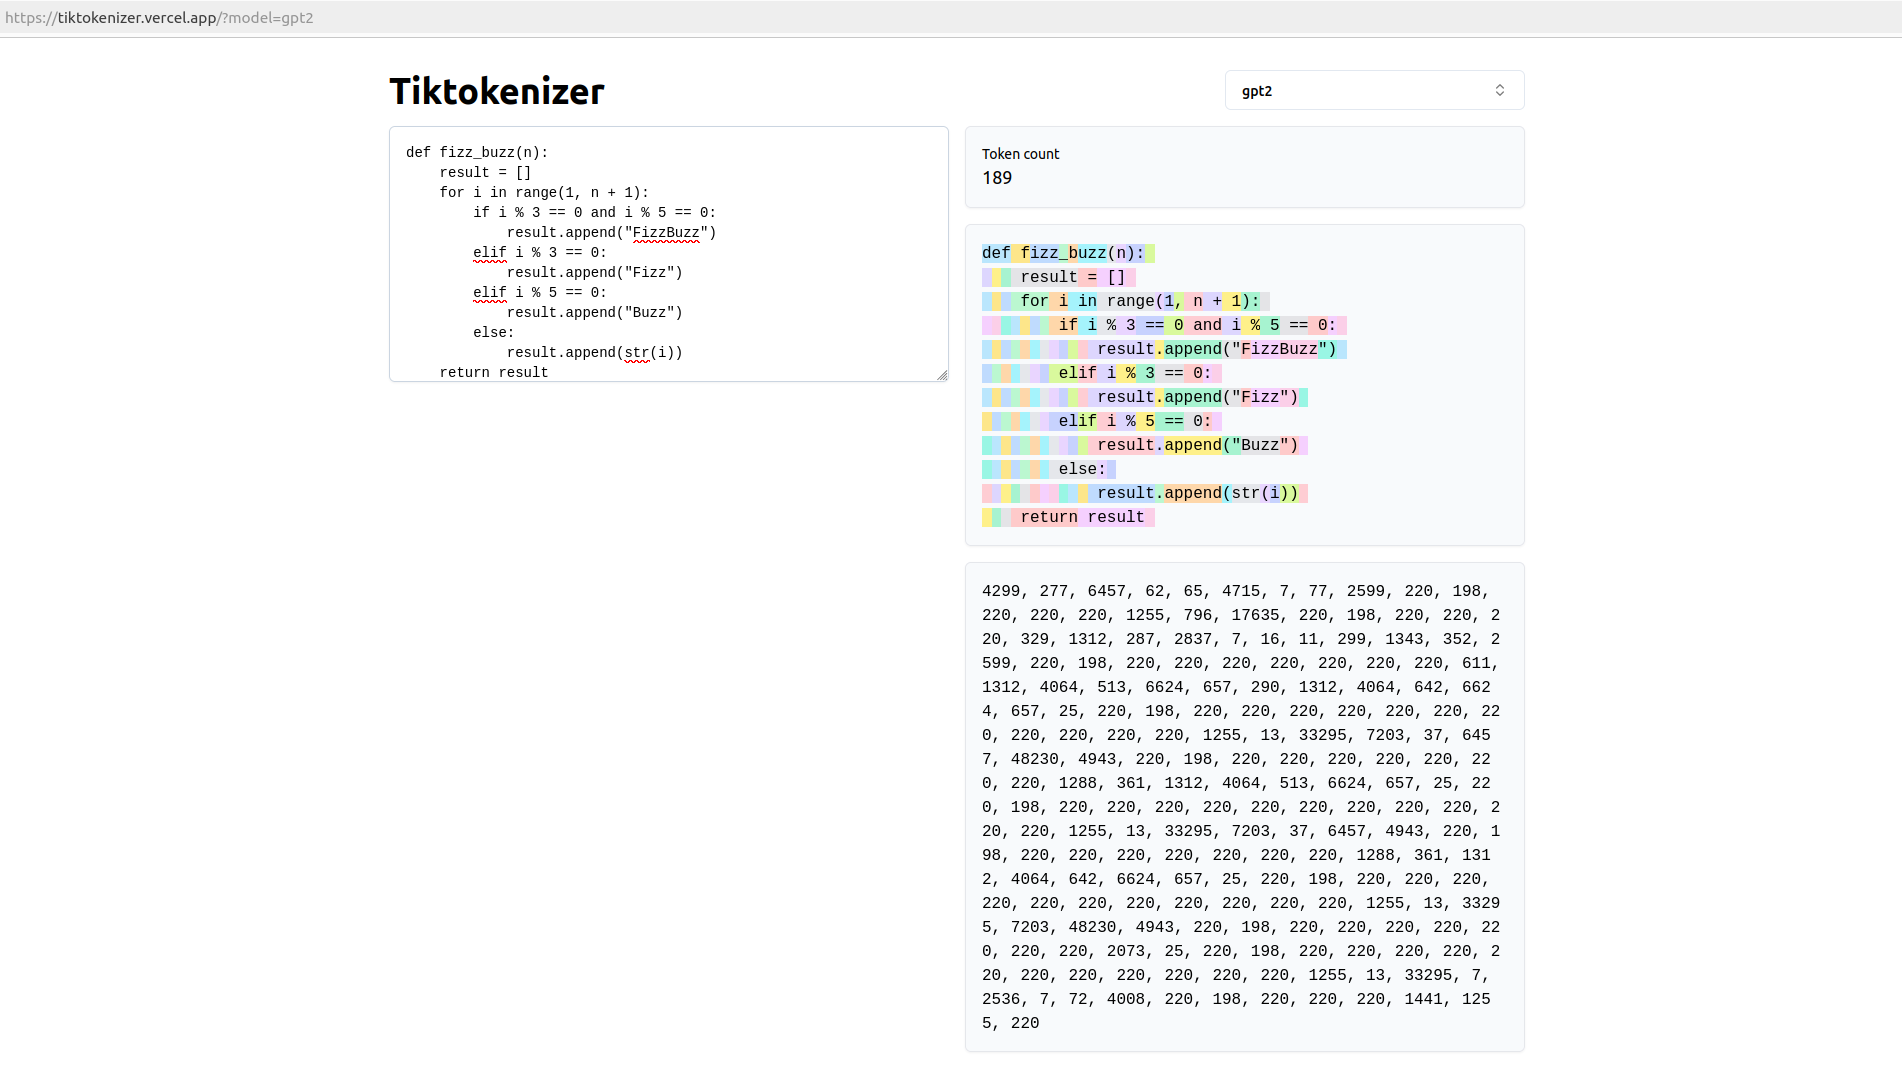

- My implementation of the BPE tokenizer with RegEx is below:

In [32]:
from tqdm import tqdm
import regex
class RegexTokenizer(BasicTokenizer):
    def __init__(self,pattern) -> None:
        super().__init__()
        self.pattern = pattern
    
    def train(self, text, vocab_size, verbose=False):
        num_merges = vocab_size - 256
        #--- Start: main regex modification ---#
        raw_tokens = [token for token in regex.findall(self.pattern, text)]
        encoded_tokens = [s.encode('utf-8') for s in raw_tokens]
        tokens = b"".join(encoded_tokens)
        #---   End: main regex modification ---#

        init_num_tokens = len(tokens)
        for i in tqdm(range(num_merges)):
            stats = RegexTokenizer.get_stats(tokens)
            #top_pair = max(stats, key=stats.get)
            max_freq = max(stats.values())
            top_pairs = [pair for pair, freq in stats.items() if freq == max_freq]
            top_pair = min(top_pairs)  # lexicographically smallest pair
            tokens = RegexTokenizer.merge(tokens, top_pair, 256+i)
            self.merges[top_pair] = 256+i
        final_num_tokens = len(tokens)
        if verbose:
            print(init_num_tokens)
            print(final_num_tokens)
            print(f"compression ratio: {init_num_tokens/final_num_tokens:.2f}")
            print(f"merges: {self.merges}")


- Breaking down the main new lines above, it appears that the encoding checks out:

In [ ]:
raw_tokens = [token for token in regex.findall(GPT2_SPLIT_PATTERN, text)]
encoded_tokens = [s.encode('utf-8') for s in raw_tokens]
tokens = b"".join(encoded_tokens) 
tokens 

b'\xef\xbc\xb5\xef\xbd\x8e\xef\xbd\x89\xef\xbd\x83\xef\xbd\x8f\xef\xbd\x84\xef\xbd\x85! \xf0\x9f\x85\xa4\xf0\x9f\x85\x9d\xf0\x9f\x85\x98\xf0\x9f\x85\x92\xf0\x9f\x85\x9e\xf0\x9f\x85\x93\xf0\x9f\x85\x94\xe2\x80\xbd \xf0\x9f\x87\xba\xe2\x80\x8c\xf0\x9f\x87\xb3\xe2\x80\x8c\xf0\x9f\x87\xae\xe2\x80\x8c\xf0\x9f\x87\xa8\xe2\x80\x8c\xf0\x9f\x87\xb4\xe2\x80\x8c\xf0\x9f\x87\xa9\xe2\x80\x8c\xf0\x9f\x87\xaa! \xf0\x9f\x98\x84 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to \xe2\x80\x9csupport Unicode\xe2\x80\x9d in our software (whatever that means\xe2\x80\x94like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don\xe2\x80\x99t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode\xe2\x80\x99s inception. A few months ago, I got intere

In [ ]:
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception. A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view. I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here."
tokenizer = RegexTokenizer(pattern=GPT2_SPLIT_PATTERN)
tokenizer.train(text,vocab_size=276,verbose=True)

100%|██████████| 20/20 [00:00<00:00, 8052.03it/s]

1116
847
compression ratio: 1.32
merges: {(101, 32): 256, (105, 110): 257, (115, 32): 258, (226, 128): 259, (32, 116): 260, (97, 110): 261, (240, 159): 262, (116, 32): 263, (97, 114): 264, (257, 103): 265, (100, 32): 266, (101, 114): 267, (44, 32): 268, (111, 114): 269, (105, 99): 270, (111, 110): 271, (260, 104): 272, (32, 115): 273, (46, 32): 274, (100, 101): 275}


- Andrej's more sophisticated implementation with handling of special tokens, saving, and loading, is below for a more authoritative reference:

In [12]:
### Karpathy's tokenizer
"""
Minimal (byte-level) Byte Pair Encoding tokenizer.

Algorithmically follows along the GPT tokenizer:
https://github.com/openai/gpt-2/blob/master/src/encoder.py

Unlike BasicTokenizer:
- RegexTokenizer handles an optional regex splitting pattern.
- RegexTokenizer handles optional special tokens.
"""
from tqdm import tqdm
import regex as re
def get_stats(ids, counts=None):
    """
    Given a list of integers, return a dictionary of counts of consecutive pairs
    Example: [1, 2, 3, 1, 2] -> {(1, 2): 2, (2, 3): 1, (3, 1): 1}
    Optionally allows to update an existing dictionary of counts
    """
    counts = {} if counts is None else counts
    for pair in zip(ids, ids[1:]): # iterate consecutive elements
        counts[pair] = counts.get(pair, 0) + 1
    return counts


def merge(ids, pair, idx):
    """
    In the list of integers (ids), replace all consecutive occurrences
    of pair with the new integer token idx
    Example: ids=[1, 2, 3, 1, 2], pair=(1, 2), idx=4 -> [4, 3, 4]
    """
    newids = []
    i = 0
    while i < len(ids):
        # if not at the very last position AND the pair matches, replace it
        if ids[i] == pair[0] and i < len(ids) - 1 and ids[i+1] == pair[1]:
            newids.append(idx)
            i += 2
        else:
            newids.append(ids[i])
            i += 1
    return newids

class Tokenizer:
    """Base class for Tokenizers"""

    def __init__(self):
        # default: vocab size of 256 (all bytes), no merges, no patterns
        self.merges = {} # (int, int) -> int
        self.pattern = "" # str
        self.special_tokens = {} # str -> int, e.g. {'<|endoftext|>': 100257}
        self.vocab = self._build_vocab() # int -> bytes

    def train(self, text, vocab_size, verbose=False):
        # Tokenizer can train a vocabulary of size vocab_size from text
        raise NotImplementedError

    def encode(self, text):
        # Tokenizer can encode a string into a list of integers
        raise NotImplementedError

    def decode(self, ids):
        # Tokenizer can decode a list of integers into a string
        raise NotImplementedError

    def _build_vocab(self):
        # vocab is simply and deterministically derived from merges
        vocab = {idx: bytes([idx]) for idx in range(256)}
        for (p0, p1), idx in self.merges.items():
            vocab[idx] = vocab[p0] + vocab[p1]
        for special, idx in self.special_tokens.items():
            vocab[idx] = special.encode("utf-8")
        return vocab

    def save(self, file_prefix):
        """
        Saves two files: file_prefix.vocab and file_prefix.model
        This is inspired (but not equivalent to!) sentencepiece's model saving:
        - model file is the critical one, intended for load()
        - vocab file is just a pretty printed version for human inspection only
        """
        # write the model: to be used in load() later
        model_file = file_prefix + ".model"
        with open(model_file, 'w') as f:
            # write the version, pattern and merges, that's all that's needed
            f.write("minbpe v1\n")
            f.write(f"{self.pattern}\n")
            # write the special tokens, first the number of them, then each one
            f.write(f"{len(self.special_tokens)}\n")
            for special, idx in self.special_tokens.items():
                f.write(f"{special} {idx}\n")
            # the merges dict
            for idx1, idx2 in self.merges:
                f.write(f"{idx1} {idx2}\n")
        # write the vocab: for the human to look at
        vocab_file = file_prefix + ".vocab"
        inverted_merges = {idx: pair for pair, idx in self.merges.items()}
        with open(vocab_file, "w", encoding="utf-8") as f:
            for idx, token in self.vocab.items():
                # note: many tokens may be partial utf-8 sequences
                # and cannot be decoded into valid strings. Here we're using
                # errors='replace' to replace them with the replacement char �.
                # this also means that we couldn't possibly use .vocab in load()
                # because decoding in this way is a lossy operation!
                s = render_token(token)
                # find the children of this token, if any
                if idx in inverted_merges:
                    # if this token has children, render it nicely as a merge
                    idx0, idx1 = inverted_merges[idx]
                    s0 = render_token(self.vocab[idx0])
                    s1 = render_token(self.vocab[idx1])
                    f.write(f"[{s0}][{s1}] -> [{s}] {idx}\n")
                else:
                    # otherwise this is leaf token, just print it
                    # (this should just be the first 256 tokens, the bytes)
                    f.write(f"[{s}] {idx}\n")

    def load(self, model_file):
        """Inverse of save() but only for the model file"""
        assert model_file.endswith(".model")
        # read the model file
        merges = {}
        special_tokens = {}
        idx = 256
        with open(model_file, 'r', encoding="utf-8") as f:
            # read the version
            version = f.readline().strip()
            assert version == "minbpe v1"
            # read the pattern
            self.pattern = f.readline().strip()
            # read the special tokens
            num_special = int(f.readline().strip())
            for _ in range(num_special):
                special, special_idx = f.readline().strip().split()
                special_tokens[special] = int(special_idx)
            # read the merges
            for line in f:
                idx1, idx2 = map(int, line.split())
                merges[(idx1, idx2)] = idx
                idx += 1
        self.merges = merges
        self.special_tokens = special_tokens
        self.vocab = self._build_vocab()
# the main GPT text split patterns, see
# https://github.com/openai/tiktoken/blob/main/tiktoken_ext/openai_public.py
GPT2_SPLIT_PATTERN = r"""'(?:[sdmt]|ll|ve|re)| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
GPT4_SPLIT_PATTERN = r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+"""


class RegexTokenizerAK(Tokenizer):
    def __init__(self, pattern=None):
        """
        - pattern: optional string to override the default (GPT-4 split pattern)
        - special_tokens: str -> int dictionary of special tokens
          example: {'<|endoftext|>': 100257}
        """
        super().__init__()
        self.pattern = GPT4_SPLIT_PATTERN if pattern is None else pattern
        self.compiled_pattern = re.compile(self.pattern)
        self.special_tokens = {}
        self.inverse_special_tokens = {}

    def train(self, text, vocab_size, verbose=False):
        assert vocab_size >= 256
        num_merges = vocab_size - 256

        # split the text up into text chunks
        text_chunks = re.findall(self.compiled_pattern, text)

        # input text preprocessing
        ids = [list(ch.encode("utf-8")) for ch in text_chunks]

        # iteratively merge the most common pairs to create new tokens
        merges = {} # (int, int) -> int
        vocab = {idx: bytes([idx]) for idx in range(256)} # idx -> bytes
        for i in range(num_merges):
            # count the number of times every consecutive pair appears
            stats = {}
            for chunk_ids in ids:
                # passing in stats will update it in place, adding up counts
                get_stats(chunk_ids, stats)
            # find the pair with the highest count
            pair = max(stats, key=stats.get)
            # mint a new token: assign it the next available id
            idx = 256 + i
            # replace all occurrences of pair in ids with idx
            ids = [merge(chunk_ids, pair, idx) for chunk_ids in ids]
            # save the merge
            merges[pair] = idx
            vocab[idx] = vocab[pair[0]] + vocab[pair[1]]
            # prints
            if verbose:
                print(f"merge {i+1}/{num_merges}: {pair} -> {idx} ({vocab[idx]}) had {stats[pair]} occurrences")

        # save class variables
        self.merges = merges # used in encode()
        self.vocab = vocab   # used in decode()

    def register_special_tokens(self, special_tokens):
        # special_tokens is a dictionary of str -> int
        # example: {"<|endoftext|>": 100257}
        self.special_tokens = special_tokens
        self.inverse_special_tokens = {v: k for k, v in special_tokens.items()}

    def decode(self, ids):
        # given ids (list of integers), return Python string
        part_bytes = []
        for idx in ids:
            if idx in self.vocab:
                part_bytes.append(self.vocab[idx])
            elif idx in self.inverse_special_tokens:
                part_bytes.append(self.inverse_special_tokens[idx].encode("utf-8"))
            else:
                raise ValueError(f"invalid token id: {idx}")
        text_bytes = b"".join(part_bytes)
        text = text_bytes.decode("utf-8", errors="replace")
        return text

    def _encode_chunk(self, text_bytes):
        # return the token ids
        # let's begin. first, convert all bytes to integers in range 0..255
        ids = list(text_bytes)
        while len(ids) >= 2:
            # find the pair with the lowest merge index
            stats = get_stats(ids)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            # subtle: if there are no more merges available, the key will
            # result in an inf for every single pair, and the min will be
            # just the first pair in the list, arbitrarily
            # we can detect this terminating case by a membership check
            if pair not in self.merges:
                break # nothing else can be merged anymore
            # otherwise let's merge the best pair (lowest merge index)
            idx = self.merges[pair]
            ids = merge(ids, pair, idx)
        return ids

    def encode_ordinary(self, text):
        """Encoding that ignores any special tokens."""
        # split text into chunks of text by categories defined in regex pattern
        text_chunks = re.findall(self.compiled_pattern, text)
        # all chunks of text are encoded separately, then results are joined
        ids = []
        for chunk in text_chunks:
            chunk_bytes = chunk.encode("utf-8") # raw bytes
            chunk_ids = self._encode_chunk(chunk_bytes)
            ids.extend(chunk_ids)
        return ids

    def encode(self, text, allowed_special="none_raise"):
        """
        Unlike encode_ordinary, this function handles special tokens.
        allowed_special: can be "all"|"none"|"none_raise" or a custom set of special tokens
        if none_raise, then an error is raised if any special token is encountered in text
        this is the default tiktoken behavior right now as well
        any other behavior is either annoying, or a major footgun
        """
        # decode the user desire w.r.t. handling of special tokens
        special = None
        if allowed_special == "all":
            special = self.special_tokens
        elif allowed_special == "none":
            special = {}
        elif allowed_special == "none_raise":
            special = {}
            assert all(token not in text for token in self.special_tokens)
        elif isinstance(allowed_special, set):
            special = {k: v for k, v in self.special_tokens.items() if k in allowed_special}
        else:
            raise ValueError(f"allowed_special={allowed_special} not understood")
        if not special:
            # shortcut: if no special tokens, just use the ordinary encoding
            return self.encode_ordinary(text)
        # otherwise, we have to be careful with potential special tokens in text
        # we handle special tokens by splitting the text
        # based on the occurrence of any exact match with any of the special tokens
        # we can use re.split for this. note that surrounding the pattern with ()
        # makes it into a capturing group, so the special tokens will be included
        special_pattern = "(" + "|".join(re.escape(k) for k in special) + ")"
        special_chunks = re.split(special_pattern, text)
        # now all the special characters are separated from the rest of the text
        # all chunks of text are encoded separately, then results are joined
        ids = []
        for part in special_chunks:
            if part in special:
                # this is a special token, encode it separately as a special case
                ids.append(special[part])
            else:
                # this is an ordinary sequence, encode it normally
                ids.extend(self.encode_ordinary(part))
        return ids

- As expected, Andrej's tokenizer works flawlessly:

In [188]:
from pathlib import Path
tokenizer = RegexTokenizerAK(pattern=GPT2_SPLIT_PATTERN)
taylor_text = Path('taylorswift.txt').read_text().strip()
tokenizer.train(taylor_text,vocab_size=1276,verbose=True)
assert tokenizer.decode(tokenizer.encode(taylor_text))==taylor_text, 'enc/dec mismatch'

100%|██████████| 1020/1020 [00:37<00:00, 27.28it/s]


## Training and comparing tokenizers on TinyStories data

- Now let's train and compare the tokenizers on subsets on the TinyStories dataset.

In [3]:
from datasets import load_dataset
tiny_stories_ds=load_dataset("roneneldan/TinyStories")

/home/mainuser/anaconda3/envs/mintonano/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
sample_list = tiny_stories_ds['train'].shuffle(seed=1337).select(range(1000))['text']

In [18]:
sample_list[:3]

['Once upon a time, there was a little girl named Lily. She loved to play with clay and make different shapes. One day, she made a good-looking horse with the clay. She was very happy and showed it to her mother.\n\nHer mother said, "Wow, Lily! That\'s a beautiful horse. Can you kneel down and show me how it runs?"\n\nLily knelt down and made the horse run with her hands. Her mother smiled and said, "You\'re so creative, Lily. Keep making more things with clay." \n\nLily smiled and said, "I will, Mommy. And maybe next time, I\'ll make a good-looking dog for you."',
 'Once upon a time, there was a mum and her two kids. The two kids were Joe and Sam. Joe and Sam did not always agree with each other. One day, the two boys had a big fight over a toy. Joe wanted to use the toy first, but Sam did not agree.\n\nSo, mum decided to take the boys to see a lawyer. The lawyer was very calm. The lawyer helped them talk with each other and figure out a solution. Eventually, the lawyer helped Joe and

In [19]:
training_corpus='<-->'.join(sample_list) # choose to use this since my basic tokenizer does not handle the special tokens
#training_corpus='<|endoftext|>'.join(sample_list)

In [20]:
print(training_corpus[:500])

Once upon a time, there was a little girl named Lily. She loved to play with clay and make different shapes. One day, she made a good-looking horse with the clay. She was very happy and showed it to her mother.

Her mother said, "Wow, Lily! That's a beautiful horse. Can you kneel down and show me how it runs?"

Lily knelt down and made the horse run with her hands. Her mother smiled and said, "You're so creative, Lily. Keep making more things with clay." 

Lily smiled and said, "I will, Mommy. A


In [33]:
tokenizer_dpv = RegexTokenizer(pattern=GPT2_SPLIT_PATTERN)
tokenizer_dpv.train(training_corpus,vocab_size=6400,verbose=True)

  0%|          | 0/6144 [00:00<?, ?it/s]

100%|██████████| 6144/6144 [03:18<00:00, 30.90it/s]

882306
147202
compression ratio: 5.99
merges: {(101, 32): 256, (100, 32): 257, (116, 104): 258, (32, 97): 259, (46, 32): 260, (116, 32): 261, (115, 32): 262, (121, 32): 263, (101, 114): 264, (110, 257): 265, (116, 111): 266, (101, 257): 267, (258, 256): 268, (105, 110): 269, (119, 97): 270, (104, 256): 271, (44, 32): 272, (111, 117): 273, (259, 265): 274, (266, 32): 275, (101, 110): 276, (104, 97): 277, (111, 109): 278, (10, 10): 279, (111, 110): 280, (32, 115): 281, (97, 114): 282, (269, 103): 283, (259, 32): 284, (105, 108): 285, (32, 268): 286, (104, 101): 287, (111, 114): 288, (97, 110): 289, (270, 262): 290, (260, 84): 291, (264, 32): 292, (105, 116): 293, (114, 101): 294, (105, 109): 295, (115, 97): 296, (108, 111): 297, (105, 100): 298, (46, 279): 299, (111, 32): 300, (258, 101): 301, (260, 83): 302, (105, 262): 303, (97, 265): 304, (108, 32): 305, (105, 114): 306, (108, 97): 307, (115, 116): 308, (260, 72): 309, (32, 104): 310, (302, 271): 311, (267, 275): 312, (105, 261): 313,

In [193]:
assert tokenizer_dpv.decode(tokenizer_dpv.encode(training_corpus[:200]))==training_corpus[:200], 'enc/dec mismatch'

In [21]:
tokenizer_ak = RegexTokenizerAK(pattern=GPT2_SPLIT_PATTERN)
tokenizer_ak.train(training_corpus,vocab_size=6400,verbose=True)

  0%|          | 0/6144 [00:00<?, ?it/s]

100%|██████████| 6144/6144 [13:57<00:00,  7.34it/s]


In [192]:
assert tokenizer_ak.decode(tokenizer_ak.encode(training_corpus[:200]))==training_corpus[:200], 'enc/dec mismatch'

In [23]:
assert tokenizer_ak.decode(tokenizer_ak.encode(training_corpus[:200]))==tokenizer_dpv.decode(tokenizer_dpv.encode(training_corpus[:200])), 'ak/dpv mismatch'

In [229]:
tokenizer_ak.decode(tokenizer_ak.encode(training_corpus[:200]))

'Once upon a time, there was a little girl named Lily. She loved to play with clay and make different shapes. One day, she made a good-looking horse with the clay. She was very happy and showed it to h'

In [164]:
text_sample = training_corpus[:1024]

- Now let's train the GPT-2 tokenizer using HuggingFace tokenizers:

In [171]:
from transformers import GPT2TokenizerFast
from tokenizers import trainers, Tokenizer


# Load the GPT-2 tokenizer
original_tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

# Get the settings from the original tokenizer
model = original_tokenizer._tokenizer.model
pre_tokenizer = original_tokenizer._tokenizer.pre_tokenizer
post_processor = original_tokenizer._tokenizer.post_processor

# Initialize a new tokenizer with the same settings
gpt2_custom = Tokenizer(model)
gpt2_custom.pre_tokenizer = pre_tokenizer
gpt2_custom.post_processor = post_processor

# Train the new tokenizer
trainer = trainers.BpeTrainer(vocab_size=6400, show_progress=True)
gpt2_custom.train_from_iterator(sample_list, trainer=trainer)


/home/mainuser/anaconda3/envs/mintonano/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


- For reference, let's also train a 'standard' BPE tokenizer where all implementation details are known:

In [ ]:
from tokenizers import Tokenizer, trainers, models, pre_tokenizers, normalizers

# Initialize a new ByteLevelBPETokenizer
bpe_tokenizer = Tokenizer(models.BPE())

# Normalize the text
bpe_tokenizer.normalizer = normalizers.Sequence([
    normalizers.NFKC(),
    normalizers.Lowercase()
])

# Pre-tokenize the text
bpe_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# Train the tokenizer
trainer = trainers.BpeTrainer(vocab_size=6400, show_progress=True)
bpe_tokenizer.train_from_iterator(sample_list, trainer=trainer)


- Before the lexicographic adjustment:

In [ ]:
print(tokenizer_dpv.encode(text))
print(len(tokenizer_dpv.encode(text)))

[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 435, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140, 240, 159, 135, 169, 226, 128, 140, 240, 159, 135, 170, 435, 240, 159, 152, 132, 32, 389, 378, 2443, 5152, 3301, 3655, 274, 97, 669, 937, 655, 697, 452, 1481, 1022, 331, 109, 2477, 2632, 119, 1268, 866, 637, 1111, 669, 273, 567, 275, 226, 128, 156, 1656, 337, 288, 261, 85, 2159, 111, 732, 226, 128, 157, 32, 549, 6378, 3206, 270, 397, 40, 3598, 1831, 356, 1541, 115, 226, 128, 148, 534, 782, 316, 119, 99, 681, 95, 261, 343, 1320, 2267, 283, 859, 1183, 63, 41, 619, 85, 2159, 111, 557, 2090, 97, 98, 308, 1310, 367, 494, 805, 1467, 937, 719, 1859, 45, 552

In [241]:
print(tokenizer_ak.encode(text))
print(len(tokenizer_ak.encode(text)))

[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140, 240, 159, 135, 169, 226, 128, 140, 240, 159, 135, 170, 33, 32, 240, 159, 152, 132, 299, 396, 1253, 2342, 778, 2407, 264, 6081, 696, 262, 3703, 345, 282, 1312, 114, 333, 109, 667, 1371, 119, 433, 46, 750, 495, 713, 366, 32, 611, 266, 32, 226, 128, 156, 115, 117, 340, 811, 4089, 474, 4759, 226, 128, 157, 315, 1097, 1431, 119, 491, 32, 40, 119, 578, 1426, 353, 2900, 226, 128, 148, 108, 1636, 3290, 260, 382, 289, 95, 116, 365, 495, 262, 733, 566, 44, 957, 63, 41, 46, 552, 4089, 474, 4759, 483, 324, 689, 362, 114, 117, 387, 44, 264, 3897, 847, 696, 26

- After the lexicographic adjustment:

In [16]:
print(tokenizer_ak.encode(text))
print(len(tokenizer_ak.encode(text)))

[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140, 240, 159, 135, 169, 226, 128, 140, 240, 159, 135, 170, 33, 32, 240, 159, 152, 132, 303, 366, 1285, 357, 324, 1355, 2631, 264, 258, 119, 101, 980, 262, 2098, 115, 338, 1827, 2010, 327, 109, 711, 1172, 119, 429, 46, 1015, 477, 746, 384, 32, 634, 267, 32, 226, 2556, 115, 117, 345, 654, 1469, 986, 111, 100, 101, 226, 128, 157, 312, 1335, 1784, 119, 493, 32, 40, 119, 104, 726, 313, 360, 1835, 115, 226, 128, 148, 108, 2506, 2293, 260, 402, 293, 95, 116, 365, 477, 262, 357, 2037, 44, 1114, 63, 41, 46, 638, 1469, 986, 111, 100, 101, 507, 328, 722, 575, 1

In [221]:
tokenizer_dpv.encode('<-->'),tokenizer_ak.encode('<-->') # Ok, encoded early on by both tokenizers

([374], [375])

- My tokenizer behaves similarly to Andrej's, with most merges happening around the same time. Both appear to possess the same compression ratio (tokenized the sample text to 454 tokens to represent text of length 1024) on the chosen sample, and both successfully recover the original sequence. The main difference seems to come from Andrej's tokenizer using *get_stats* on each chunk separately and merging pairs within the chunks separately, while mine merges pairs within the entire concatenated byte string.  While this is slower (13:57 vs 03:18 on my machine), it is a more careful (and likely more 'correct') handling of the individual chunks.  I would imagine the modern highly optimized tokenizers to perform tokenization on multiple chunks of text in parallel, aligning best with Andrej's implementation. 

- However, GPT-2 tokenizer appears to yield different tokens even with same vocabulary size.  It also differs from the standard BPE tokenizer available from Hugging Face.  Since not all details of GPT-2 tokenizer implementation are known (referring to 4-spaces not being merged for Python code, for example), this could be due to a custom implementation detail of GPT-2.

In [242]:
print(gpt2_custom.encode(text_sample).ids)
print(len(gpt2_custom.encode(text)))

[248, 261, 81, 212, 4, 216, 103, 81, 209, 260, 321, 182, 6, 136, 309, 89, 195, 162, 4781, 87, 395, 1036, 1676, 6, 333, 178, 4, 155, 370, 81, 419, 5, 3323, 1709, 162, 85, 4781, 6, 136, 103, 215, 227, 87, 999, 125, 89, 135, 1062, 6, 72, 72, 1080, 1062, 145, 4, 154, 1188, 4, 182, 0, 1032, 190, 81, 610, 1709, 6, 1174, 175, 3679, 470, 87, 528, 354, 541, 125, 1703, 295, 72, 72, 164, 3973, 470, 87, 370, 85, 1709, 631, 162, 135, 799, 6, 677, 1062, 307, 87, 145, 4, 154, 341, 1207, 170, 3040, 4, 182, 6, 4921, 1011, 496, 464, 162, 4781, 235, 228, 72, 164, 307, 87, 145, 4, 154, 23, 500, 4, 944, 6, 792, 2025, 894, 212, 4, 158, 1466, 395, 81, 419, 5, 3323, 536, 188, 175, 235, 5155, 248, 261, 81, 212, 4, 216, 103, 81, 808, 87, 135, 729, 1049, 6, 122, 729, 1049, 253, 813, 87, 455, 6, 813, 87, 455, 287, 219, 452, 3404, 162, 628, 412, 6, 333, 178, 4, 85, 729, 1772, 186, 81, 220, 1515, 582, 81, 314, 6, 813, 267, 89, 1072, 85, 314, 1117, 4, 234, 455, 287, 219, 3404, 6, 72, 72, 762, 4, 808, 462, 89, 492, 8

In [243]:
print(bpe_tokenizer.encode(text_sample).ids)
print(len(bpe_tokenizer.encode(text)))

[211, 228, 56, 182, 4, 183, 79, 56, 177, 226, 282, 150, 6, 86, 277, 64, 162, 132, 4495, 63, 360, 971, 1574, 6, 220, 148, 4, 86, 334, 56, 376, 5, 3147, 1606, 132, 58, 4495, 6, 86, 79, 185, 196, 63, 934, 90, 64, 105, 966, 6, 47, 47, 217, 966, 119, 4, 125, 1110, 4, 150, 0, 145, 158, 56, 558, 1606, 6, 249, 126, 3479, 424, 63, 474, 313, 462, 90, 1601, 260, 47, 47, 393, 3752, 424, 63, 334, 58, 1606, 586, 132, 105, 742, 6, 105, 966, 275, 63, 119, 4, 125, 697, 1125, 131, 2871, 4, 150, 6, 755, 945, 448, 420, 132, 4495, 201, 197, 47, 393, 275, 63, 119, 4, 125, 23, 447, 4, 369, 6, 63, 1029, 811, 182, 4, 174, 1372, 360, 56, 376, 5, 3147, 489, 156, 126, 201, 4857, 3410, 228, 56, 182, 4, 183, 79, 56, 579, 63, 105, 666, 981, 6, 58, 666, 981, 222, 748, 63, 379, 6, 748, 63, 379, 253, 189, 407, 3230, 132, 575, 373, 6, 220, 148, 4, 58, 666, 1664, 153, 56, 188, 1400, 529, 56, 461, 6, 748, 233, 64, 1002, 58, 461, 1000, 4, 154, 379, 253, 189, 3230, 6, 47, 47, 468, 4, 579, 419, 64, 443, 58, 1664, 64, 303, 56

- It is noteworthy that tokenizer trained directly from GPT-2 tokenizer using the Hugging Face library yielded a smaller compression ratio than the BPE tokenizer (344 vs 314 tokens to represent text of length 1024), and the compression ratio of these tokenizers was larger than that of our custom tokenizers. 
- Also, both GPT-2 and BPE tokenizer appear to be highly optimized, taking less than a second to train on our sample compared to minutes, implying that it's the best move to understand the tokenization process and use an optimized off-the-shelf implementation.  

## Additional discussion

- Andrej makes a number or important points in the second half of the [Let's build the GPT Tokenizer](https://www.youtube.com/watch?v=zduSFxRajkE) video.  

### tiktoken and GPT-4 tokenizer

- GPT-4 tokenizer fixed the case sensitivity pointed out above by making the match pattern case insensitive.
- In additional to the encoder and decoder, GPT-2 also has byte_encoder and byte_decoder methods that don't add substantially to the implementation.  
- GPT-2 tokenizer's vocab size of 50257 comes from 256 raw byte tokens, 50000 merges, and the <|endoftext|> token.  
- Modern tokenizers, such as the gpt-3.5-turbo tokenizer, also have other special tokens such as <|imstart|>, <|imend|>, etc, where 'im' stands for 'imaginary monologue' to delimit chat conversations, for example.  tiktoken library allows addition of these special tokens. 
- Adding special tokens necessitates transformer model surgery to add the tokens in the embedding matrix and the classifier layer.
- As noted above, tiktoken does not provide the *train* function, just the inference code.

### sentencepiece

- *sentencepiece* provices a train function and works on the level of code points, not bytes, falling back to UTF-8 if it encounters unknown tokens.
- It also tries to split out sentences, which could be challenging since many syntactic units do not squarely fall within sentence/no-sentence category. 
- By default *sentencepiece* adds white spaces in front of strings that are not at the start of sentences for consistency of treating words occurring at the start and in the middle of sentences.
- In Andrej's experience, *sentencepiece* documentation is lacking a bit at the moment.

### Vocab size, finetuning with new tokens,Gisting, and transformers for non-language models

- With larger vocabulary size, more tokens can be compressed and included within a given context length, but there would also be fewer of a given token for a language model to train on.
- While the greater amount of information included within a context window is generally beneficial, too much of it due to a large vocab size is likely not give the model enough time to 'think' as it's attending to the tokens.  Thus vocab size can be viewed as a hyperparameter of the model.
- If we're finetuning and want to add special tokens (eg, for using a browser), we would resize the embedding and the weights, then could freeze the original weights and finetune *just* the new parameters.
- There is a gist tokens compression technique where new tokens are introduced and the model is trained by distillation, training just the embedding representations of the new tokens such that the behavior of this language model is identical to that of a model with a very long prompt.  This is shown in the following diagram:

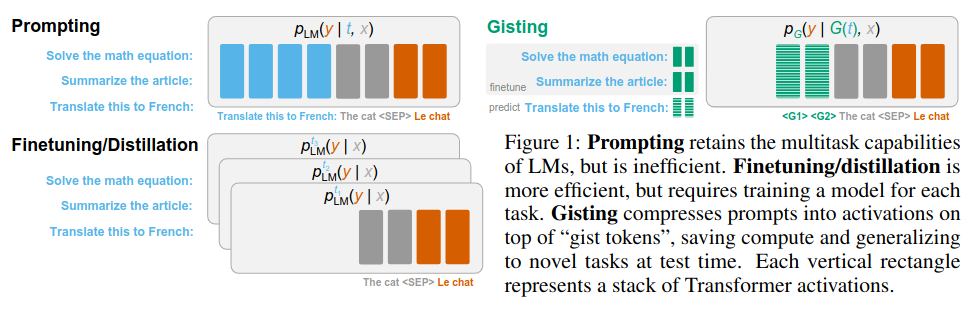

- It is also possible to tokenize non-language data (eg, images), and use the transformer architecture for autoregressive or diffusion models (Sora is an example).

### Looping back to issues arising from tokenization
- Andrej's answers to the following questions are below.


- Why can't LLM spell words? 
    - AK: Characters are chunked up into tokens, some of which are long (a model with a ':DefaultCellStyle' token will not be able to answer spelling questions about it).  Also, if ':DefaultCellSty' is passed to the model, the model generation will likely stop since it has never seen just a chunk of the token in it's vocabulary and such chunks are outside of the model's distribution.
- Why can't LLM do super simple string processing tasks like reversing a string? 
    - AK: Similarly, reversing a single long token would be challenging to a model unless it's first prompted to list out the individual characters.  
- Why is LLM worse at non-English languages (e.g. Japanese)? 
    - AK: Tokenizers are not sufficiently trained on non-English data and as a consequence do not compress it sufficiently.
- Why is LLM bad at simple arithmetic? 
    - AK: Addition algorithm is character-level, yet integers are not split up consistently (sometimes into 1, or 2, or 3 digits).
- Why did GPT-2 have more than necessary trouble coding in Python? 
    - AK: Encoding efficiency of the GPT-2 tokenizer was not great since tabs did not get encoded into single tokens, for example.
- Why did my LLM abruptly halt when it sees the string "<|endoftext|>"? 
    - AK: Something is breaking as this token does not seem to be handled properly: questions to LLMs containing it end up unanswered as this token appears to be parsed when it shouldn't be when coming from a user that could attack the system.
- What is this weird warning I get about a "trailing whitespace"? 
    - AK: Prompting ending in trailing space sent to instruct models cause sampling inefficiency since tokens at the beginning of words already start with a space and adding an extra space is out of distribution for the model.  
- Why did the LLM break if I ask it about "SolidGoldMagikarp"? 
    - AK: There's an internet-famous [blog](https://www.lesswrong.com/posts/aPeJE8bSo6rAFoLqg/solidgoldmagikarp-plus-prompt-generation) examining clusters of tokens based on their embeddings.  When these tokens are used in questions to an LLM that had these tokens in its tokenizer, the model may respond with evasion, hallucination, insults, etc.  The likely cause of this is the discrepancy between tokenization and training datasets.  In the tokenization dataset, tokens for popular Reddit users such as  SolidGoldMagikarp got merged into their own tokens.  However, the token likely never appeared in the training data, and the token never got sampled and 'trained'.  Then at test time, giving this token to the model leads to undefined behavior.  
- Why should I prefer to use YAML over JSON with LLMs? 
    - AK: YAMLs generally end up being tokenized into fewer tokens than JSONs and hence are more economical.  
- Why is LLM not actually end-to-end language modeling? 
    - AK: Tokenization. 
- What is the real root of suffering? 
    - AK: Andrej really dislikes tokenization ( ͡° ͜ʖ ͡°)


## References

Mu, J., Li, X. L., & Goodman, N. (2023). Learning to compress prompts with gist tokens. arXiv preprint arXiv:2304.08467. doi: 10.48550/arXiv.2304.08467

Radford, A., Wu, J., Child, R., Luan, D., Amodei, D., & Sutskever, I. (2019). Language models are unsupervised multitask learners. Technical report, OpenAI.